In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download, read in, preprocess data

In [3]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=False)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=False)
    labeled_data.to_csv()

Reading csv


In [4]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [5]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3031,2017-11-22,25.7,0.0,0.6,0.2,22.7,23.9
3034,2017-11-22,47.0,3.0,0.0,0.3,24.8,29.9
3031,2017-11-23,55.4,25.7,0.0,0.6,0.2,22.7
3034,2017-11-23,53.1,47.0,3.0,0.0,0.3,24.8
3007,2017-11-29,9.3,14.4,5.7,0.3,0.0,2.9
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


In [6]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(25)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.0,0.1,0.3,0.900,1.7
3007,2020-04-30,6280.500,0.0,0.0,0.2,1.300,1.5
3009,2020-04-30,6280.900,0.0,0.0,0.3,1.200,1.6
3010,2020-04-30,6280.500,0.0,0.0,0.2,1.100,2.2
3011,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.0
3012,2020-04-30,6280.500,0.0,0.0,0.0,0.300,0.7
3013,2020-04-30,6280.858,0.0,0.0,0.1,0.600,1.1
3014,2020-04-30,6280.500,0.0,0.0,0.0,0.200,0.1
3015,2020-04-30,6280.500,0.0,0.0,0.0,0.700,1.1


In [7]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [9]:
labels = labels.drop(drop_idx)

In [10]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12970, 5238)
Shape of labels    :  (12970, 69)


In [11]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In [12]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    df.drop(col_list, axis=1, inplace=True)
    return df

In [13]:
def sum_over_features(df, col_list, new_name, drop=False):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [14]:
def take_max(df, col_list, new_name, drop=False):
    """
    Create a column for the max value given over the past 3 days (72 hours).
    This will drop the input columns in col_list if drop is set to True.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for creating the max value
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
    
    Returns:
        df(DataFrame): same input data frame with new max value column
    """
    # take the max over rows
    df[new_name] = df.loc[:, col_list].max(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [15]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [16]:
max_sum_cols = [col for col in regions.columns if '72hr' in col]
train = regions.loc[:, max_sum_cols]
train

,,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,
3031,2017-11-22,24.0,26.3,-3.5
3034,2017-11-22,33.0,50.0,-2.0
3031,2017-11-23,39.5,81.1,3.0
3034,2017-11-23,46.0,103.1,3.0
3007,2017-11-29,29.5,29.4,-4.1
...,...,...,...,...
3031,2021-01-12,20.0,15.0,-5.0
3032,2021-01-12,26.5,3.0,-9.0
3034,2021-01-12,23.5,16.0,-7.0


In [17]:
def scale_input_data(X):
    """
    Scale input features from [-1, 1] so that it is easier to
    train a neural network.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(X)
    return scaled

In [18]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,
3031,2017-11-22,-0.421687,-0.655721,-0.057781
3034,2017-11-22,-0.204819,-0.345477,0.008330
3031,2017-11-23,-0.048193,0.061636,0.228701
3034,2017-11-23,0.108434,0.349627,0.228701
3007,2017-11-29,-0.289157,-0.615140,-0.084226
...,...,...,...,...
3031,2021-01-12,-0.518072,-0.803643,-0.123893
3032,2021-01-12,-0.361446,-0.960729,-0.300190
3034,2021-01-12,-0.433735,-0.790553,-0.212041


In [19]:
print(np.any(np.isnan(train)))

False


In [20]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3031,2017-11-22,4
3034,2017-11-22,4
3031,2017-11-23,4
3034,2017-11-23,4
3007,2017-11-29,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


# Split data

In [21]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [22]:
print(len(train_idx), len(X_train), len(y_train))
print(len(val_idx), len(X_val), len(y_val))
print(len(test_idx), len(X_test), len(y_test))

16 16 16
3 3 3
3 3 3


In [23]:
print(np.any(np.isnan(np.concatenate(X_train))))

False


In [24]:
plotx = X_train[0]
ploty = y_train[0]
wind = plotx[:, 0]
temp = plotx[:, 2] 
precip = plotx[:, 1]

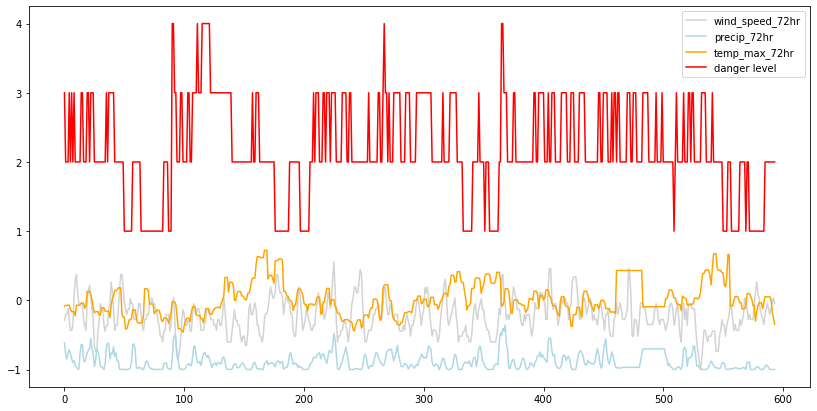

In [25]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(wind, color='lightgrey', label='wind_speed_72hr')
ax.plot(precip, color='lightblue', label='precip_72hr')
ax.plot(temp, color='orange', label='temp_max_72hr')
ax.plot(ploty, color='r', label='danger level')

ax.legend()
plt.show()

Below, you will see that each input data-label pair (representing one region) have the same number of rows (observations), and that there are > 300 observations for some regions. This is because we are stacking multiple seasons together for the same region.

In [26]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(594, 3) (594, 1)
(594, 3) (594, 1)
(594, 3) (594, 1)
(594, 3) (594, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)
(595, 3) (595, 1)
(593, 3) (593, 1)
(341, 3) (341, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)


In [27]:
for (arr, label) in zip(X_val, y_val):
    print(arr.shape, label.shape)

(594, 3) (594, 1)
(593, 3) (593, 1)
(593, 3) (593, 1)


In [28]:
for (arr, label) in zip(X_test, y_test):
    print(arr.shape, label.shape)

(174, 3) (174, 1)
(592, 3) (592, 1)
(595, 3) (595, 1)


In [29]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    #padded = np.concatenate([to_add, arr])
    
    return padded

**Maybe instead of padding, we should cut off data where it doesn't fit into full batches?**

In [30]:
sequence_length = 8
X_train = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test = [pad_sequence(arr, sequence_length) for arr in y_test]

In [31]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(344, 3) (344, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [32]:
# reshape data into (samples, timesteps, features)
# https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/
X_concat_train = np.concatenate(X_train)
y_concat_train = np.concatenate(y_train)

X_concat_val = np.concatenate(X_val)
y_concat_val = np.concatenate(y_val)

print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(9344, 3)
(9344, 1)
(1800, 3)
(1800, 1)


In [33]:
def batch_data(x, y, length):
    """
    Batch the neural network data, creating a shifting window of data at each time step.
    """    
    #create empty lists to append to
    X, Y = [], []
    
    #iterate over dataset, looking at moving window of 1 timestep
    #need to length to prevent out of bounds errors
    for i in range(0, len(x)-length):
        x_batch = x[i:length+i]
        y_batch = y[length+i]
        
        #append batches to lists
        X.append(x_batch)
        Y.append(y_batch)
    
    #convert lists to numpy arrays before turning into torch tensors
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    print(X.shape, Y.shape)
    return X, Y

In [34]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)

(9336, 8, 3) (9336, 1)
(1792, 8, 3) (1792, 1)


### Note

One thing I can't quite wrap my head around yet is how to stop one region from bleeing into the next during training. So for example, you have regions A and B. Region A is of length 600, and region B is of length 344 (both being evenly divisible by 8). As you get near the end of of region A's data, especially for a RNN where the order of data matters, are you teaching the network to expect the beginning of region B's data to match up temporally with the end of region A's data?

In [35]:
to_print = 10
print(y_concat_train[sequence_length:sequence_length+to_print], '\n')
for i in range(to_print):
    print(i, batchX_train[i], batchY_train[i], '\n')

[[3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [2.]
 [2.]] 

0 [[-0.28915663 -0.61514043 -0.08422584]
 [-0.20481928 -0.78269834 -0.07541099]
 [-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]] [3.] 

1 [[-0.20481928 -0.78269834 -0.07541099]
 [-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]
 [ 0.06024096 -0.87302252 -0.16355943]] [2.] 

2 [[-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]
 [ 0.06024096 -0.87302252 -0.16355943]
 [ 0.28915663 -0.9

In [36]:
print(np.any(np.isnan(batchX_train)))

False


## Training a neural network

### DNN

Next, we can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

input_neurons = 100
output_neurons = len(np.unique(batchY_train))
batch_size = 8
drop = 0.25

timesteps = batchX_train.shape[1]
features = batchX_train.shape[2]

# design network
dnn = tf.keras.models.Sequential()
dnn.add(Dense(input_neurons, activation='relu', input_shape=(timesteps, features)))
dnn.add(Dropout(drop))
dnn.add(Dense(input_neurons, activation='relu'))
dnn.add(Dropout(drop))
dnn.add(tf.keras.layers.Flatten())
dnn.add(Dense(output_neurons, activation='softmax'))

dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8, 100)            400       
_________________________________________________________________
dropout (Dropout)            (None, 8, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 100)            10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 100)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 4005      
Total params: 14,505
Trainable params: 14,505
Non-trainable params: 0
____________________________________________________

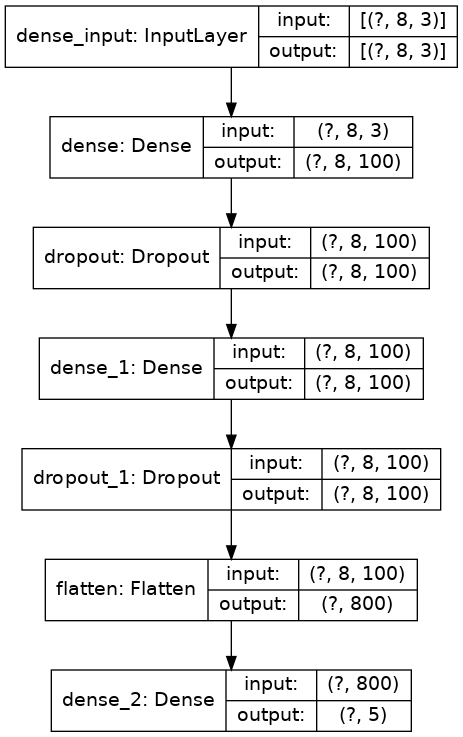

In [38]:
# being able to print model architectures in tensorflow is
# dependent on having pydot and graphviz packages installed
tf.keras.utils.plot_model(dnn, 'dnn_architecture.png', show_shapes=True)

Below, I have used sparse categorical crossentropy as my loss function instead of plain old categorical crossentropy. My understanding of why this is useful is that you don't need to one-hot encode your labels. So instead of having n-columns in your output labels for n labels, you can instead use a single vector (which is how our labels are formatted). Alongside that, you should use sparse categorical accuracy instead of accuracy in your reporting metrics.

In [39]:
# specify hyperparams here
num_epochs = 250
alpha = 1e-3
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)
#optimizer = tf.keras.optimizers.SGD(lr=0.0001)

# compile and fit model
dnn.compile(loss=criterion, 
              optimizer=optimizer, 
              metrics=['sparse_categorical_accuracy'])

dnn_history = dnn.fit(batchX_train, batchY_train, 
                      validation_data=(batchX_val, batchY_val),
                      epochs=num_epochs, verbose=1, shuffle=False)

Epoch 1/250
292/292 [==============================] - 1s 4ms/step - loss: 1.1222 - sparse_categorical_accuracy: 0.5095 - val_loss: 1.1660 - val_sparse_categorical_accuracy: 0.5212
Epoch 2/250
292/292 [==============================] - 1s 4ms/step - loss: 1.0488 - sparse_categorical_accuracy: 0.5352 - val_loss: 1.1328 - val_sparse_categorical_accuracy: 0.5167
Epoch 3/250
292/292 [==============================] - 1s 4ms/step - loss: 1.0133 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.5212
Epoch 4/250
292/292 [==============================] - 1s 4ms/step - loss: 0.9891 - sparse_categorical_accuracy: 0.5570 - val_loss: 1.0951 - val_sparse_categorical_accuracy: 0.5324
Epoch 5/250
292/292 [==============================] - 1s 4ms/step - loss: 0.9766 - sparse_categorical_accuracy: 0.5562 - val_loss: 1.0753 - val_sparse_categorical_accuracy: 0.5402
Epoch 6/250
292/292 [==============================] - 1s 4ms/step - loss: 0.9647 - sparse_cate

292/292 [==============================] - 1s 2ms/step - loss: 0.8534 - sparse_categorical_accuracy: 0.6188 - val_loss: 0.9426 - val_sparse_categorical_accuracy: 0.5737
Epoch 47/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8558 - sparse_categorical_accuracy: 0.6189 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.5709
Epoch 48/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8566 - sparse_categorical_accuracy: 0.6169 - val_loss: 0.9441 - val_sparse_categorical_accuracy: 0.5759
Epoch 49/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8557 - sparse_categorical_accuracy: 0.6156 - val_loss: 0.9461 - val_sparse_categorical_accuracy: 0.5737
Epoch 50/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8540 - sparse_categorical_accuracy: 0.6199 - val_loss: 0.9511 - val_sparse_categorical_accuracy: 0.5804
Epoch 51/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8538 - sparse_categorical

292/292 [==============================] - 1s 2ms/step - loss: 0.8289 - sparse_categorical_accuracy: 0.6368 - val_loss: 0.9222 - val_sparse_categorical_accuracy: 0.5887
Epoch 92/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8303 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.5848
Epoch 93/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8264 - sparse_categorical_accuracy: 0.6309 - val_loss: 0.9305 - val_sparse_categorical_accuracy: 0.5865
Epoch 94/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8257 - sparse_categorical_accuracy: 0.6298 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.5898
Epoch 95/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8281 - sparse_categorical_accuracy: 0.6297 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.5826
Epoch 96/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8261 - sparse_categorical

Epoch 136/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8083 - sparse_categorical_accuracy: 0.6405 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.5876
Epoch 137/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8094 - sparse_categorical_accuracy: 0.6422 - val_loss: 0.9063 - val_sparse_categorical_accuracy: 0.5893
Epoch 138/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8128 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.9100 - val_sparse_categorical_accuracy: 0.5859
Epoch 139/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8081 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.9090 - val_sparse_categorical_accuracy: 0.5893
Epoch 140/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8096 - sparse_categorical_accuracy: 0.6394 - val_loss: 0.9110 - val_sparse_categorical_accuracy: 0.5876
Epoch 141/250
292/292 [==============================] - 1s 2ms/step - loss: 0.8127 -

Epoch 181/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7903 - sparse_categorical_accuracy: 0.6457 - val_loss: 0.8970 - val_sparse_categorical_accuracy: 0.5988
Epoch 182/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7947 - sparse_categorical_accuracy: 0.6436 - val_loss: 0.8962 - val_sparse_categorical_accuracy: 0.5938
Epoch 183/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7973 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.8965 - val_sparse_categorical_accuracy: 0.5876
Epoch 184/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7916 - sparse_categorical_accuracy: 0.6457 - val_loss: 0.8941 - val_sparse_categorical_accuracy: 0.5921
Epoch 185/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7928 - sparse_categorical_accuracy: 0.6443 - val_loss: 0.8934 - val_sparse_categorical_accuracy: 0.5921
Epoch 186/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7975 -

Epoch 226/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7853 - sparse_categorical_accuracy: 0.6470 - val_loss: 0.8974 - val_sparse_categorical_accuracy: 0.5904
Epoch 227/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7879 - sparse_categorical_accuracy: 0.6517 - val_loss: 0.8926 - val_sparse_categorical_accuracy: 0.5854
Epoch 228/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7793 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.9000 - val_sparse_categorical_accuracy: 0.5798
Epoch 229/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7808 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.9066 - val_sparse_categorical_accuracy: 0.5804
Epoch 230/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7829 - sparse_categorical_accuracy: 0.6515 - val_loss: 0.8986 - val_sparse_categorical_accuracy: 0.5876
Epoch 231/250
292/292 [==============================] - 1s 2ms/step - loss: 0.7809 -

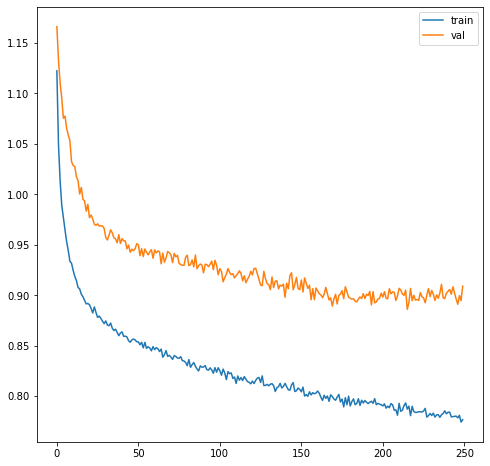

In [40]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(dnn_history.history['loss'], label='train')
ax.plot(dnn_history.history['val_loss'], label='val')

ax.legend()
plt.show()

We are now overfitting, but we were okay until epoch ~225. We could actually continue to run this network to improve the performance if we used some regularization. Both the training and validation loss are continuing to decrease. If regularization makes it so that we are underfitting, we could then train for longer or train a bigger neural network.

Reference: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

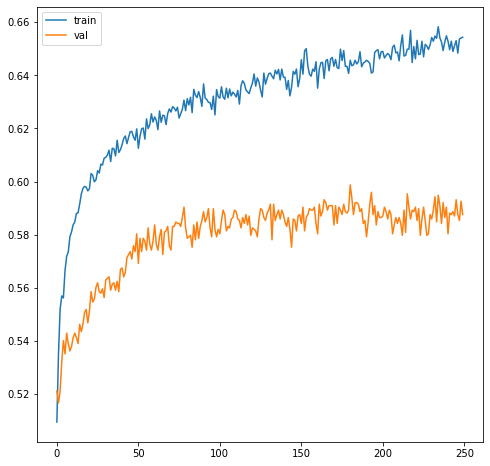

In [41]:
# plot accuracy
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(dnn_history.history['sparse_categorical_accuracy'], label='train')
ax.plot(dnn_history.history['val_sparse_categorical_accuracy'], label='val')

ax.legend()
plt.show()

This is not that great of accuracy, but that could improve with hyperparameters tuning and being able to train longer. Let's try that below.

In [42]:
input_neurons = 100
output_neurons = len(np.unique(batchY_train))
batch_size = 8
drop = 0.25
regularizer = tf.keras.regularizers.l2(l=0.001)

timesteps = batchX_train.shape[1]
features = batchX_train.shape[2]

# design network
dnn_reg = tf.keras.models.Sequential()
dnn_reg.add(Dense(input_neurons, activation='relu', kernel_regularizer=regularizer, input_shape=(timesteps, features)))
dnn_reg.add(Dropout(drop))
dnn_reg.add(Dense(input_neurons, activation='relu', kernel_regularizer=regularizer))
dnn_reg.add(Dropout(drop))
dnn_reg.add(tf.keras.layers.Flatten())
dnn_reg.add(Dense(output_neurons, activation='softmax'))

dnn_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8, 100)            400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 100)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 8, 100)            10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 100)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 4005      
Total params: 14,505
Trainable params: 14,505
Non-trainable params: 0
__________________________________________________

**Note**: I am not sure how common it is to use both dropout layers and L2 regularization. I need to read more about this.

In [43]:
num_epochs = 250
alpha = 1e-3
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

# compile and fit model
dnn_reg.compile(loss=criterion, 
                optimizer=optimizer, 
                metrics=['sparse_categorical_accuracy'])

dnn_reg_history = dnn_reg.fit(batchX_train, batchY_train, 
                              validation_data=(batchX_val, batchY_val),
                              epochs=num_epochs, verbose=1, shuffle=False)

Epoch 1/250
292/292 [==============================] - 1s 2ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.5075 - val_loss: 1.1955 - val_sparse_categorical_accuracy: 0.5257
Epoch 2/250
292/292 [==============================] - 1s 2ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.1923 - val_sparse_categorical_accuracy: 0.5206
Epoch 3/250
292/292 [==============================] - 1s 2ms/step - loss: 1.0575 - sparse_categorical_accuracy: 0.5460 - val_loss: 1.1703 - val_sparse_categorical_accuracy: 0.5251
Epoch 4/250
292/292 [==============================] - 1s 2ms/step - loss: 1.0309 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.1474 - val_sparse_categorical_accuracy: 0.5262
Epoch 5/250
292/292 [==============================] - 1s 2ms/step - loss: 1.0162 - sparse_categorical_accuracy: 0.5534 - val_loss: 1.1320 - val_sparse_categorical_accuracy: 0.5335
Epoch 6/250
292/292 [==============================] - 1s 2ms/step - loss: 1.0036 - sparse_cate

292/292 [==============================] - 1s 2ms/step - loss: 0.9208 - sparse_categorical_accuracy: 0.5982 - val_loss: 1.0141 - val_sparse_categorical_accuracy: 0.5597
Epoch 47/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9194 - sparse_categorical_accuracy: 0.5948 - val_loss: 1.0195 - val_sparse_categorical_accuracy: 0.5575
Epoch 48/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9204 - sparse_categorical_accuracy: 0.5952 - val_loss: 1.0105 - val_sparse_categorical_accuracy: 0.5580
Epoch 49/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9180 - sparse_categorical_accuracy: 0.5962 - val_loss: 1.0243 - val_sparse_categorical_accuracy: 0.5525
Epoch 50/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9203 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.0180 - val_sparse_categorical_accuracy: 0.5569
Epoch 51/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9180 - sparse_categorical

292/292 [==============================] - 1s 2ms/step - loss: 0.9078 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.9889 - val_sparse_categorical_accuracy: 0.5658
Epoch 92/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9093 - sparse_categorical_accuracy: 0.6031 - val_loss: 0.9780 - val_sparse_categorical_accuracy: 0.5737
Epoch 93/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9066 - sparse_categorical_accuracy: 0.6056 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.5653
Epoch 94/250
292/292 [==============================] - 1s 3ms/step - loss: 0.9060 - sparse_categorical_accuracy: 0.6056 - val_loss: 0.9890 - val_sparse_categorical_accuracy: 0.5720
Epoch 95/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9091 - sparse_categorical_accuracy: 0.6052 - val_loss: 0.9847 - val_sparse_categorical_accuracy: 0.5698
Epoch 96/250
292/292 [==============================] - 1s 2ms/step - loss: 0.9088 - sparse_categorical

Epoch 136/250
292/292 [==============================] - 1s 3ms/step - loss: 0.9033 - sparse_categorical_accuracy: 0.6067 - val_loss: 0.9738 - val_sparse_categorical_accuracy: 0.5759
Epoch 137/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8994 - sparse_categorical_accuracy: 0.6069 - val_loss: 0.9698 - val_sparse_categorical_accuracy: 0.5837
Epoch 138/250
292/292 [==============================] - 1s 3ms/step - loss: 0.9052 - sparse_categorical_accuracy: 0.6036 - val_loss: 0.9680 - val_sparse_categorical_accuracy: 0.5798
Epoch 139/250
292/292 [==============================] - 1s 3ms/step - loss: 0.9015 - sparse_categorical_accuracy: 0.6066 - val_loss: 0.9681 - val_sparse_categorical_accuracy: 0.5770
Epoch 140/250
292/292 [==============================] - 1s 3ms/step - loss: 0.9019 - sparse_categorical_accuracy: 0.6087 - val_loss: 0.9696 - val_sparse_categorical_accuracy: 0.5798
Epoch 141/250
292/292 [==============================] - 1s 3ms/step - loss: 0.9019 -

Epoch 181/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8984 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.9541 - val_sparse_categorical_accuracy: 0.5843
Epoch 182/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8978 - sparse_categorical_accuracy: 0.6086 - val_loss: 0.9622 - val_sparse_categorical_accuracy: 0.5798
Epoch 183/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8966 - sparse_categorical_accuracy: 0.6116 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.5809
Epoch 184/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8966 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.9617 - val_sparse_categorical_accuracy: 0.5848
Epoch 185/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8952 - sparse_categorical_accuracy: 0.6101 - val_loss: 0.9569 - val_sparse_categorical_accuracy: 0.5859
Epoch 186/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8983 -

Epoch 226/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8960 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.9534 - val_sparse_categorical_accuracy: 0.5843
Epoch 227/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8946 - sparse_categorical_accuracy: 0.6097 - val_loss: 0.9613 - val_sparse_categorical_accuracy: 0.5820
Epoch 228/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8946 - sparse_categorical_accuracy: 0.6048 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.5887
Epoch 229/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8974 - sparse_categorical_accuracy: 0.6099 - val_loss: 0.9590 - val_sparse_categorical_accuracy: 0.5871
Epoch 230/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8957 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.9568 - val_sparse_categorical_accuracy: 0.5898
Epoch 231/250
292/292 [==============================] - 1s 3ms/step - loss: 0.8903 -

These printouts are long. I could try to shorten these by writing a custom training loop like I've done before in PyTorch.

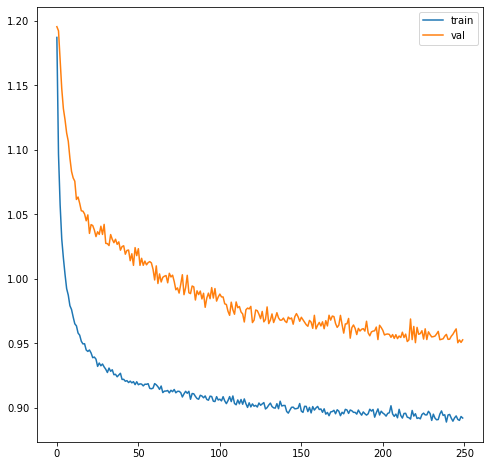

In [44]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(dnn_reg_history.history['loss'], label='train')
ax.plot(dnn_reg_history.history['val_loss'], label='val')

ax.legend()
plt.show()

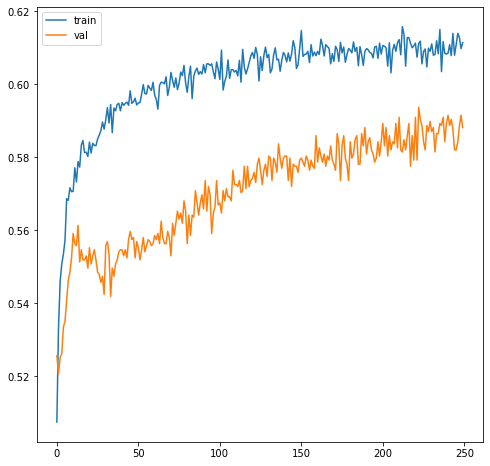

In [45]:
# plot accuracy
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(dnn_reg_history.history['sparse_categorical_accuracy'], label='train')
ax.plot(dnn_reg_history.history['val_sparse_categorical_accuracy'], label='val')

ax.legend()
plt.show()

We could keep training with this regularization value.

### LSTM

We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [51]:
input_neurons = 64
output_neurons = len(np.unique(batchY_train))
batch_size = 8
drop = 0.25

timesteps = batchX_train.shape[1]
features = batchX_train.shape[2]

# design network
model = tf.keras.models.Sequential()
model.add(LSTM(input_neurons, input_shape=(timesteps, features)))
model.add(Dense(input_neurons, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(output_neurons, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 21,893
Trainable params: 21,893
Non-trainable params: 0
_________________________________________________________________


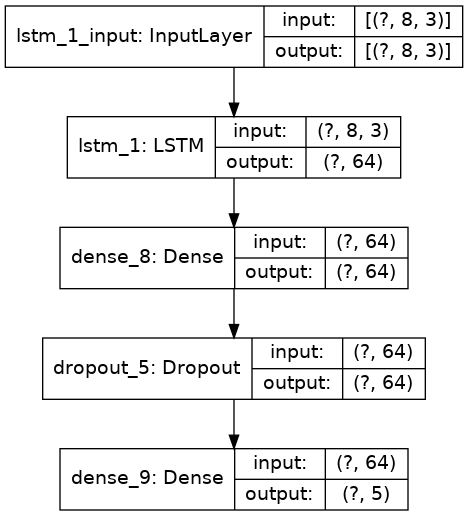

In [52]:
tf.keras.utils.plot_model(model, 'lstm_architecture.png', show_shapes=True)

In [53]:
# specify hyperparams here
num_epochs = 100
alpha = 1e-3
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

# compile and fit model
model.compile(loss=criterion, 
              optimizer=optimizer, 
              metrics=['sparse_categorical_accuracy'])

history = model.fit(batchX_train, batchY_train, 
                    validation_data=(batchX_val, batchY_val),
                    epochs=num_epochs, verbose=1, shuffle=False)

Epoch 1/100
292/292 [==============================] - 1s 3ms/step - loss: 1.1781 - sparse_categorical_accuracy: 0.4929 - val_loss: 1.1846 - val_sparse_categorical_accuracy: 0.4972
Epoch 2/100
292/292 [==============================] - 1s 2ms/step - loss: 1.1024 - sparse_categorical_accuracy: 0.5135 - val_loss: 1.1655 - val_sparse_categorical_accuracy: 0.5151
Epoch 3/100
292/292 [==============================] - 1s 2ms/step - loss: 1.0710 - sparse_categorical_accuracy: 0.5278 - val_loss: 1.1746 - val_sparse_categorical_accuracy: 0.5078
Epoch 4/100
292/292 [==============================] - 1s 2ms/step - loss: 1.0459 - sparse_categorical_accuracy: 0.5378 - val_loss: 1.1697 - val_sparse_categorical_accuracy: 0.4916
Epoch 5/100
292/292 [==============================] - 1s 2ms/step - loss: 1.0217 - sparse_categorical_accuracy: 0.5380 - val_loss: 1.1639 - val_sparse_categorical_accuracy: 0.4715
Epoch 6/100
292/292 [==============================] - 1s 2ms/step - loss: 1.0078 - sparse_cate

292/292 [==============================] - 1s 2ms/step - loss: 0.8340 - sparse_categorical_accuracy: 0.6298 - val_loss: 0.9921 - val_sparse_categorical_accuracy: 0.5725
Epoch 47/100
292/292 [==============================] - 1s 2ms/step - loss: 0.8354 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.9734 - val_sparse_categorical_accuracy: 0.5748
Epoch 48/100
292/292 [==============================] - 1s 2ms/step - loss: 0.8331 - sparse_categorical_accuracy: 0.6347 - val_loss: 0.9575 - val_sparse_categorical_accuracy: 0.5831
Epoch 49/100
292/292 [==============================] - 1s 2ms/step - loss: 0.8262 - sparse_categorical_accuracy: 0.6311 - val_loss: 0.9702 - val_sparse_categorical_accuracy: 0.5765
Epoch 50/100
292/292 [==============================] - 1s 2ms/step - loss: 0.8238 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.9761 - val_sparse_categorical_accuracy: 0.5792
Epoch 51/100
292/292 [==============================] - 1s 2ms/step - loss: 0.8189 - sparse_categorical

292/292 [==============================] - 1s 2ms/step - loss: 0.6623 - sparse_categorical_accuracy: 0.7070 - val_loss: 1.0707 - val_sparse_categorical_accuracy: 0.6016
Epoch 92/100
292/292 [==============================] - 1s 2ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.7155 - val_loss: 1.0819 - val_sparse_categorical_accuracy: 0.5988
Epoch 93/100
292/292 [==============================] - 1s 2ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.7108 - val_loss: 1.0820 - val_sparse_categorical_accuracy: 0.6027
Epoch 94/100
292/292 [==============================] - 1s 2ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.0672 - val_sparse_categorical_accuracy: 0.6027
Epoch 95/100
292/292 [==============================] - 1s 2ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.7120 - val_loss: 1.0849 - val_sparse_categorical_accuracy: 0.6021
Epoch 96/100
292/292 [==============================] - 1s 2ms/step - loss: 0.6435 - sparse_categorical

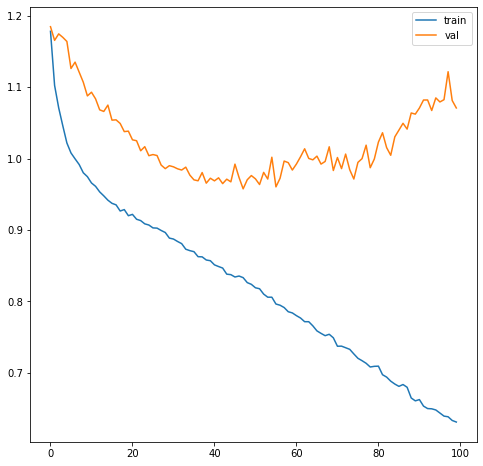

In [54]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')

ax.legend()
plt.show()

This looks like a classic case of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Our validation loss starts increasing and our training loss continues decreasing. We could try to fix this with trying to add regularization to our network, or using a different architecture (maybe with less layers or neurons per layer).

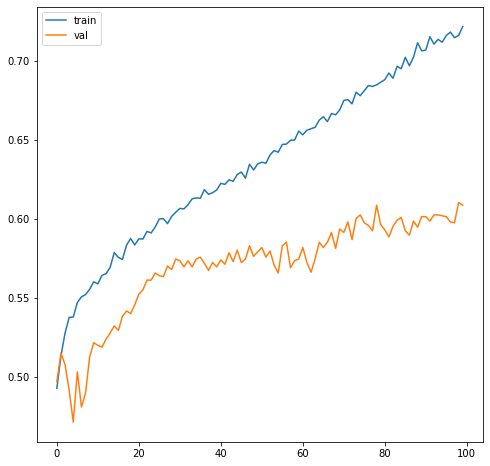

In [55]:
# plot accuracy
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['sparse_categorical_accuracy'], label='train')
ax.plot(history.history['val_sparse_categorical_accuracy'], label='val')

ax.legend()
plt.show()

Let's run a smaller network and see how that performs.

In [56]:
input_neurons = 16
output_neurons = len(np.unique(batchY_train))
batch_size = 8
drop = 0.25

timesteps = batchX_train.shape[1]
features = batchX_train.shape[2]

# design network
model = tf.keras.models.Sequential()
model.add(LSTM(input_neurons, input_shape=(timesteps, features)))
model.add(Dense(input_neurons, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(output_neurons, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1280      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 85        
Total params: 1,637
Trainable params: 1,637
Non-trainable params: 0
_________________________________________________________________


In [57]:
# specify hyperparams here
num_epochs = 150
alpha = 1e-3
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

# compile and fit model
model.compile(loss=criterion, 
              optimizer=optimizer, 
              metrics=['sparse_categorical_accuracy'])

history = model.fit(batchX_train, batchY_train, 
                    validation_data=(batchX_val, batchY_val),
                    epochs=num_epochs, verbose=1, shuffle=False)

Epoch 1/150
292/292 [==============================] - 1s 3ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.1631 - val_sparse_categorical_accuracy: 0.4888
Epoch 2/150
292/292 [==============================] - 1s 2ms/step - loss: 1.1417 - sparse_categorical_accuracy: 0.5019 - val_loss: 1.1362 - val_sparse_categorical_accuracy: 0.4888
Epoch 3/150
292/292 [==============================] - 1s 2ms/step - loss: 1.1128 - sparse_categorical_accuracy: 0.5067 - val_loss: 1.1249 - val_sparse_categorical_accuracy: 0.4888
Epoch 4/150
292/292 [==============================] - 1s 2ms/step - loss: 1.0968 - sparse_categorical_accuracy: 0.5071 - val_loss: 1.1196 - val_sparse_categorical_accuracy: 0.4894
Epoch 5/150
292/292 [==============================] - 1s 2ms/step - loss: 1.0832 - sparse_categorical_accuracy: 0.5092 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.4978
Epoch 6/150
292/292 [==============================] - 1s 2ms/step - loss: 1.0655 - sparse_cate

292/292 [==============================] - 1s 2ms/step - loss: 0.9430 - sparse_categorical_accuracy: 0.5732 - val_loss: 1.0101 - val_sparse_categorical_accuracy: 0.5636
Epoch 47/150
292/292 [==============================] - 1s 2ms/step - loss: 0.9437 - sparse_categorical_accuracy: 0.5763 - val_loss: 1.0120 - val_sparse_categorical_accuracy: 0.5608
Epoch 48/150
292/292 [==============================] - 1s 2ms/step - loss: 0.9412 - sparse_categorical_accuracy: 0.5732 - val_loss: 1.0090 - val_sparse_categorical_accuracy: 0.5642
Epoch 49/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9410 - sparse_categorical_accuracy: 0.5758 - val_loss: 1.0007 - val_sparse_categorical_accuracy: 0.5681
Epoch 50/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9420 - sparse_categorical_accuracy: 0.5686 - val_loss: 0.9969 - val_sparse_categorical_accuracy: 0.5653
Epoch 51/150
292/292 [==============================] - 1s 2ms/step - loss: 0.9376 - sparse_categorical

292/292 [==============================] - 1s 3ms/step - loss: 0.9124 - sparse_categorical_accuracy: 0.5942 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.5703
Epoch 92/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9072 - sparse_categorical_accuracy: 0.5972 - val_loss: 0.9418 - val_sparse_categorical_accuracy: 0.5737
Epoch 93/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9059 - sparse_categorical_accuracy: 0.5935 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.5770
Epoch 94/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9107 - sparse_categorical_accuracy: 0.5928 - val_loss: 0.9428 - val_sparse_categorical_accuracy: 0.5759
Epoch 95/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9042 - sparse_categorical_accuracy: 0.5951 - val_loss: 0.9341 - val_sparse_categorical_accuracy: 0.5742
Epoch 96/150
292/292 [==============================] - 1s 3ms/step - loss: 0.9027 - sparse_categorical

Epoch 136/150
292/292 [==============================] - 1s 3ms/step - loss: 0.8772 - sparse_categorical_accuracy: 0.6106 - val_loss: 0.9156 - val_sparse_categorical_accuracy: 0.5949
Epoch 137/150
292/292 [==============================] - 1s 3ms/step - loss: 0.8787 - sparse_categorical_accuracy: 0.6135 - val_loss: 0.9195 - val_sparse_categorical_accuracy: 0.5915
Epoch 138/150
292/292 [==============================] - 1s 3ms/step - loss: 0.8794 - sparse_categorical_accuracy: 0.6118 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.5915
Epoch 139/150
292/292 [==============================] - 1s 3ms/step - loss: 0.8798 - sparse_categorical_accuracy: 0.6119 - val_loss: 0.9156 - val_sparse_categorical_accuracy: 0.5904
Epoch 140/150
292/292 [==============================] - 1s 3ms/step - loss: 0.8793 - sparse_categorical_accuracy: 0.6117 - val_loss: 0.9054 - val_sparse_categorical_accuracy: 0.5943
Epoch 141/150
292/292 [==============================] - 1s 2ms/step - loss: 0.8786 -

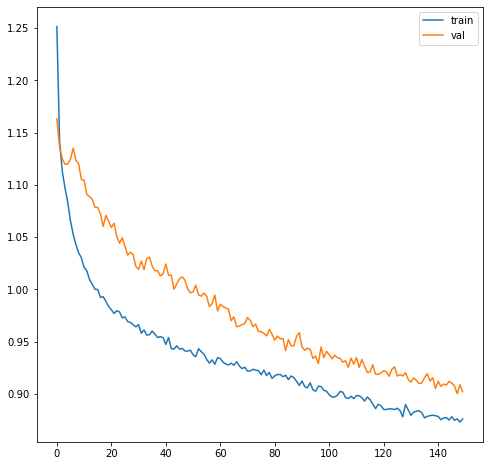

In [58]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')

ax.legend()
plt.show()

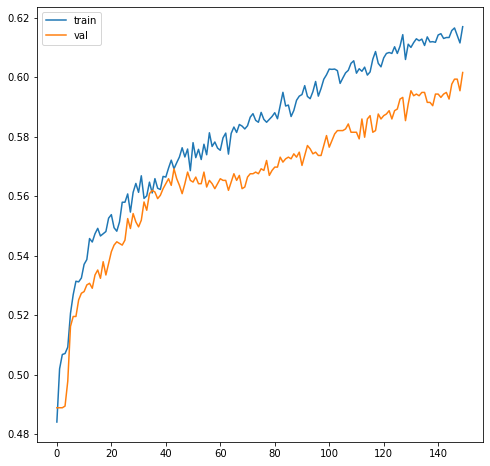

In [59]:
# plot accuracy
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['sparse_categorical_accuracy'], label='train')
ax.plot(history.history['val_sparse_categorical_accuracy'], label='val')

ax.legend()
plt.show()

Much better.

## Thoughts
- I wonder what would happen if we fed in the danger level (or avalanche problem #1) labels from the previous day in adition to the meteorological variables?
- What would happen if we didn't use a sliding window for the input data? So instead of having (n\*window_size, window_size, features) you would have data with shape (n, 1, features). A DNN might be able to predict classes better this way, and it would solve the data-blending issue discussed above. You would then have to get the data like so:
```python
for each array in input data list
    X_train = X_train[:, :-1]
    # because we want to be able to predict the next day's
    # danger level, avlanche problem, etc.
    y_train = y_train[1:]
```
Then we could concatenate the data without worrying about blending different regions together. And that is what this tutorial shows: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ . At least in the DNN case, we could even shuffle the data.

- I would also like to try hyperparameter optimization with [`hyperopt`](https://hyperopt.github.io/hyperopt/).